In [34]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from scipy.interpolate import interp1d
from gwpy.time import tconvert
import pickle
import sys
sys.path.append('../src')

from likelihood_better import MDCGaussianNoise2

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [8]:
psd = np.loadtxt('../../../ET_MDC_PySTAMPAS/ET10km_columns.txt', usecols=(0,3))

tsd1 = TimeSeries.read('../data/loudest_BBH/loudest_E1.gwf', channel='E1:STRAIN')
tsd2 = TimeSeries.read('../data/loudest_BBH/loudest_E2.gwf', channel='E2:STRAIN')
tsd3 = TimeSeries.read('../data/loudest_BBH/loudest_E3.gwf', channel='E3:STRAIN')

In [29]:
ftmap1 = tsd1.fftgram(1, 0.5)
ftmap1 = ftmap1.crop_frequencies(5, 250)
psd_of_f = interp1d(psd[:,0], psd[:,1])
psd1 = psd_of_f(ftmap1.frequencies)
ftmap1 = ftmap1 / psd1**0.5

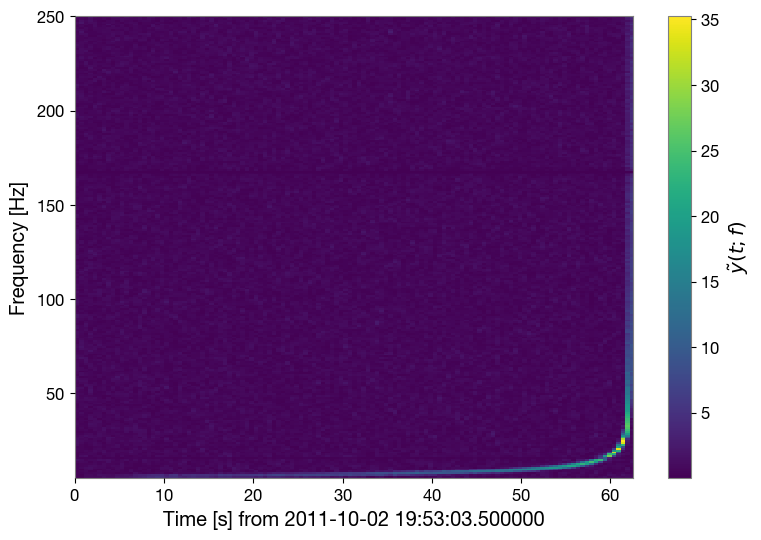

In [30]:
plt.figure(figsize=(9,6))
t0 = tconvert(ftmap1.t0.value)
ax = plt.gca()
f = ax.imshow(
    ftmap1.abs(),
    origin="lower",
    extent=(0, ftmap1.xspan[1] - ftmap1.xspan[0], ftmap1.yspan[0], ftmap1.yspan[1]),
    aspect="auto",
)
ax.grid()
ax.set_xlabel("Time [s] from " + str(t0))
ax.set_ylabel("Frequency [Hz]")
plt.colorbar(f, ax=ax, label=r"$\tilde{y}(t;f)$")


In [35]:
with open('model_optimized.pkl', 'rb') as f:
    model = pickle.load(f)

In [40]:
signal_reconstructed = model.reconstruct_signal()
tsd_r1 = signal_reconstructed['E1'].to_timeseries() # Reconstructed time series in E1
tsd_r1 = TimeSeries.from_pycbc(tsd_r1)
ftmap_r1 = tsd_r1.fftgram(1, 0.5)
ftmap_r1 = ftmap_r1.crop_frequencies(5, 250)
psd_r1 = psd_of_f(ftmap_r1.frequencies)
ftmap_r1 = ftmap_r1 / psd1**0.5

Waveform approximate duration: 55.1s
Segment duration: 64.0s


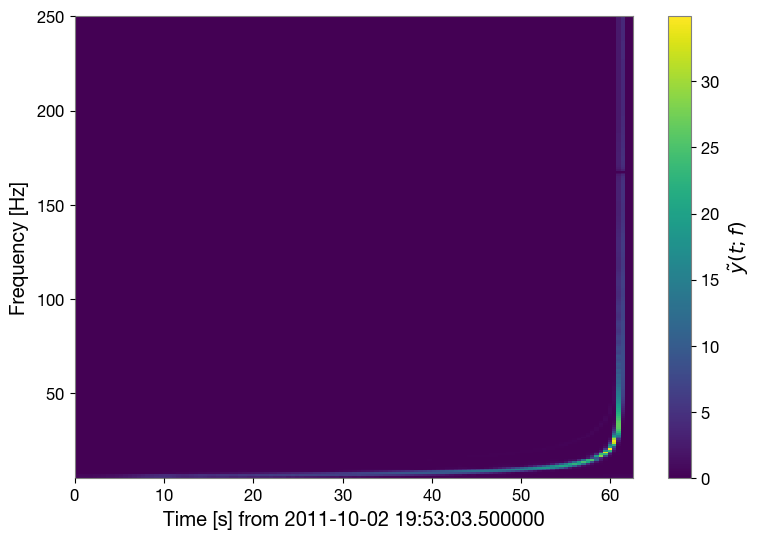

In [41]:
plt.figure(figsize=(9,6))
t0 = tconvert(ftmap_r1.t0.value)
ax = plt.gca()
f = ax.imshow(
    ftmap_r1.abs(),
    origin="lower",
    extent=(0, ftmap1.xspan[1] - ftmap_r1.xspan[0], ftmap_r1.yspan[0], ftmap_r1.yspan[1]),
    aspect="auto",
)
ax.grid()
ax.set_xlabel("Time [s] from " + str(t0))
ax.set_ylabel("Frequency [Hz]")
plt.colorbar(f, ax=ax, label=r"$\tilde{y}(t;f)$")


In [47]:


t1 = tsd1.times.value
t2 = tsd_r1.times.value

h1 = tsd1.value
h2 = tsd_r1.value

h_of_t = interp1d(t2, h2, bounds_error=False, fill_value=0)
h_new = h_of_t(t1)

residual = TimeSeries(h1 - h_new, times=t1)

ftmap_residual = residual.fftgram(1, 0.5)
ftmap_residual = ftmap_residual.crop_frequencies(5, 250)
psd_residual = psd_of_f(ftmap_residual.frequencies)
ftmap_residual = ftmap_residual / psd_residual**0.5

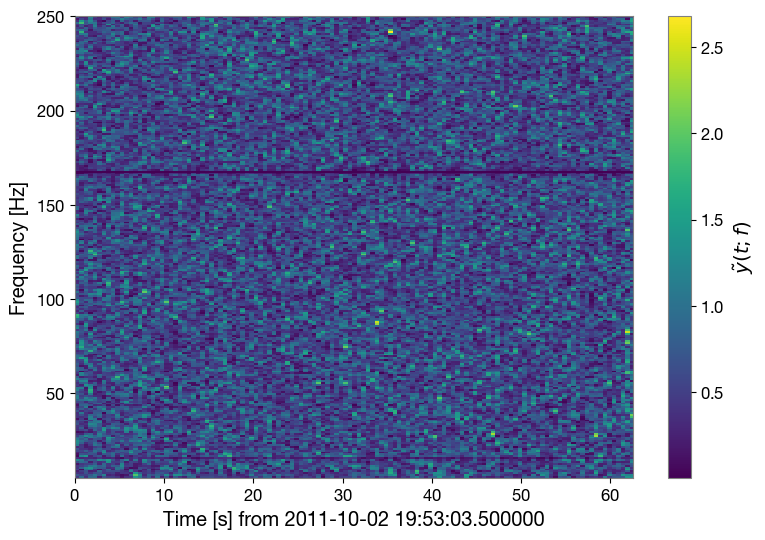

In [48]:
plt.figure(figsize=(9,6))
t0 = tconvert(ftmap_residual.t0.value)
ax = plt.gca()
f = ax.imshow(
    ftmap_residual.abs(),
    origin="lower",
    extent=(0, ftmap_residual.xspan[1] - ftmap_residual.xspan[0], ftmap_residual.yspan[0], ftmap_residual.yspan[1]),
    aspect="auto",
)
ax.grid()
ax.set_xlabel("Time [s] from " + str(t0))
ax.set_ylabel("Frequency [Hz]")
plt.colorbar(f, ax=ax, label=r"$\tilde{y}(t;f)$")


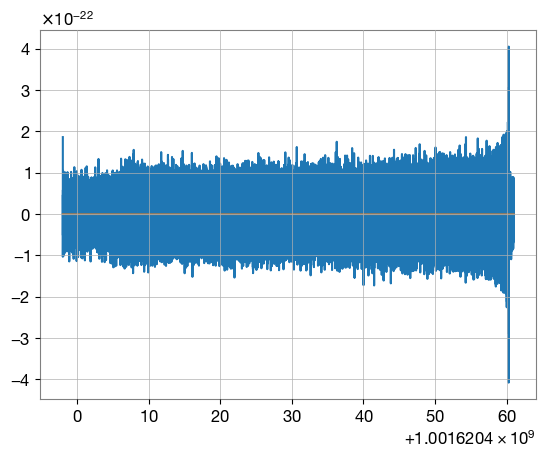

In [55]:
ifft = model.data['E1'].to_timeseries()
plt.plot(tsd1.times, tsd1)
plt.plot(ifft.get_sample_times(), ifft.data - tsd1.value, alpha=0.5)

In [52]:
tsd1.shape

(258048,)